# Gaussian XOR and Gaussian R-XOR BTE with Supervised Alignment

One key goal of progressive learning is to be able to continually improve upon past performance with the introduction of new data, without forgetting too much of the past tasks. This transfer of information can be evaluated using a generalization of Pearl's transfer-benefit ratio (TBR) to evaluate the backward direction.
As described in Vogelstein, et al. (2020), the backward transfer efficiency of task $f_n$ for task $t$ given $n$ samples is:

$$BTE^t (f_n) := \mathbb{E} [R^t (f_n^{<t} )/R^t (f_n)]$$

If $BTE^t(f_n) > 1$, the algorithm demonstrates positive backward transfer, i.e. data from the current task has been used to improve performance on past tasks.

Progressive learning in a simple environment can therefore be demonstrated using two simple tasks: Gaussian XOR and Gaussian R-XOR. Here, backward transfer efficiency is the ratio of generalization errors for XOR. These two tasks share the same discriminant boundaries, so learning can be easily transferred between them. However, as we have seen in the original Guassian XOR and Gaussian R-XOR Experiment, backward transfer efficiency can suffer if the new task differs too much from past tasks.

In this experiment, we will try to mitigate the detriment of adding new tasks that are too different by adapting the domain of the new task to the domain of the old task, but maintaining the uniquely sampled distribution of the new task. We acheive this by aligning new tasks to old tasks with an affine point set registration, found through the ICP algorithm described in [Besl & McKay (1992)](https://ieeexplore.ieee.org/document/121791). This is a simple yet effective algorithm for affine rigid registration. 

This experiment differentiates itself from the CPD experiment, as this approach aligns tasks with label supervision instead of purely aligning distributions in an unsupervised manner. 

In [1]:
import numpy as np

#import functions.xor_rxor_with_icp_functions as fn
import functions.xor_rxor_with_icp_functions_does_KNN_help as fn
from proglearn.sims import generate_gaussian_parity

Using TensorFlow backend.
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\progl

## Classification Problem with Domain Adaptation

First, let's visualize Gaussian XOR, Gaussian R-XOR, and Gaussian R-XOR adapted to XOR.

Gaussian XOR is a two-class classification problem, where...

* Class 0 is drawn from two Gaussians with $\mu = \pm [0.5, 0.5]^T$ and $\sigma^2 = I$.
* Class 1 is drawn from two Gaussians with $\mu = \pm [0.5, -0.5]^T$ and $\sigma^2 = I$. 

Gaussian R-XOR has the same distribution as Gaussian XOR, but with the class labels at different degree angle
Gaussian R-XOR adapted to XOR will be an unrotated version of the above R-XOR version to match XOR. We will call this adapted XOR or A-XOR for short.

Within the proglearn package, we can make use of the simulations within the sims folder to generate simulated data. 

The generate_gaussian_parity function within gaussian_sim.py can be used to create the Gaussian XOR and R-XOR problems. Let's generate data and plot it to see what these problems look like!

Additionaly, we will be using the ICP algorithm from functions/xor_rxor_with_icp_functions.py to adapt our R-XOR to XOR, producing A-XOR. Observe that the distribution of points matches exatly with the generated R-XOR, except the angle is rotated to match XOR.

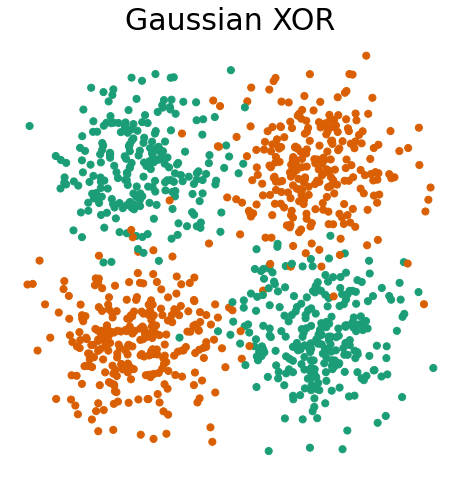

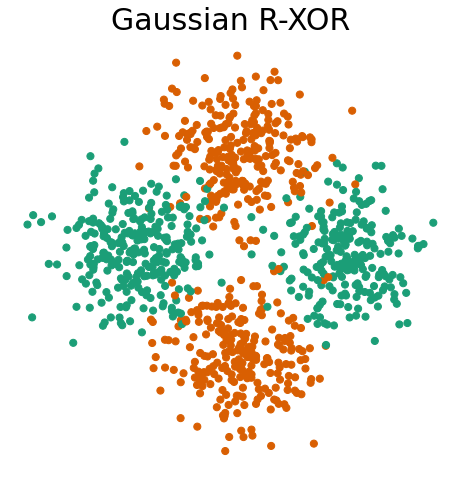

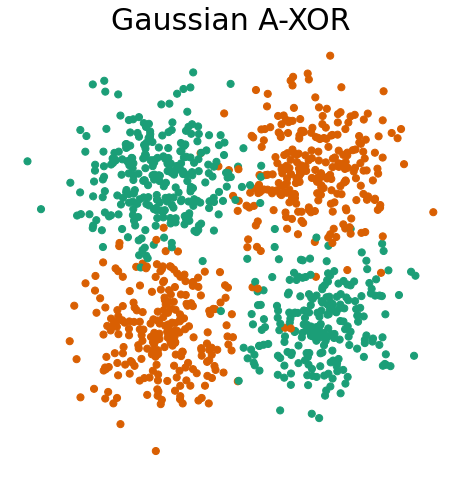

In [2]:
# call function to return gaussian xor and r-xor data:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi/4)
# call function to adapt r-xor to xor:
T, X_axor, i = fn.icp(X_rxor.copy(), X_xor.copy(), y_rxor.copy(), y_xor.copy())
X_axor = X_axor.T[:,0:2]

# plot and format:
fn.plot_xor_rxor(X_xor, y_xor, 'Gaussian XOR')
fn.plot_xor_rxor(X_rxor, y_rxor, 'Gaussian R-XOR')
fn.plot_xor_rxor(X_axor, y_rxor, 'Gaussian A-XOR')

## The Experiment (Various Angles vs BTE)

Now that we have generated the data, we can prepare to run the experiment. The function for running the experiment, experiment, can be found within functions/xor_rxor_with_icp_functions.py.

In this experiment, we will be running two progressive learning classifiers. One classifier will be given a XOR task and a R-XOR task (adaptation off). One classifier will be given a XOR task and a R-XOR task adapted to the original XOR i.e. A-XOR (adaptation on). The backward transfer efficiency of both classifiers will be evaluated over a wide range of angles of the R-XOR task.

We first declare the hyperparameters to be used for the experiment, which are as follows:
* `mc_rep`: number of repetitions to run the progressive learning algorithm for
* `angle_sweep`: angles to test
* `task1_sample`: number of task 1 samples
* `task2_sample`: number of task 2 samples

In [3]:
angle_sweep = range(0,91,10)
task1_sample = 1000
task2_sample = 1000
mc_rep = 100

First, we will run the classifier with adaptation off:

In [4]:
mean_te1 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Don

Next, we will run the classifier with adaptation on:

In [5]:
mean_te2 = fn.bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Don

Lastly, plot the results:

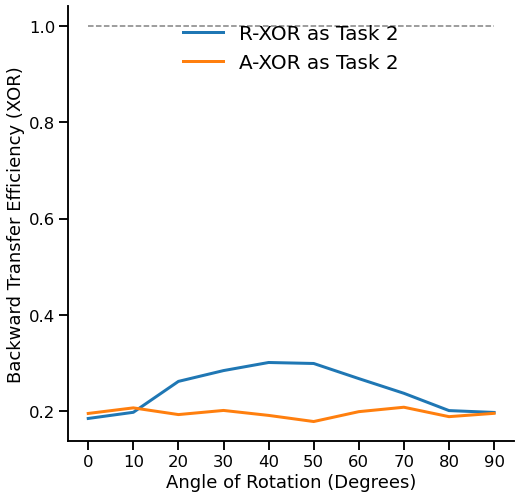

In [6]:
fn.plot_bte_v_angle(angle_sweep, mean_te1, mean_te2)